In [ ]:
import os
import pandas as pd
from utils.evaluation_utils import get_temporal_analyis_results
from pathlib import Path
import matplotlib.pyplot as plt
if "notebooks" in os.getcwd():
    os.chdir("..")
import matplotlib as mpl
import numpy as np

In [38]:
# Comment out for latex style font rendering (you need it installed on your system)
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],
    "axes.labelsize": 14,
    "font.size": 16,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.latex.preamble": r"\usepackage{amsmath}",
    "legend.title_fontsize": 10
})

In [ ]:
temporal_results_path = Path("data/results/temporal_analysis.csv")
# if not temporal_results_path.exists():
if True:
    temporal_results = get_temporal_analyis_results(
        {
            1: [i for i in range(24, 72)]
            + [i for i in range(88, 104)]
            + [i for i in range(104, 140)]
            + [184],  # 101 runs
            4: [i for i in range(63, 111)]
            + [i for i in range(127, 143)]
            + [i for i in range(143, 179)]
            + [183],  # 101 runs
            8: [i for i in range(22, 70)]
            + [i for i in range(86, 102)]
            + [i for i in range(107, 143)]
            + [147],  # 100 runs
        }
    )
    temporal_results.to_csv(temporal_results_path, index=False)

303
    run_id forecasting_hours model_architecture  look_back_hours resolution  \
0       24                 1                mlp                1      10min   
1       25                 1                mlp                4      10min   
2       26                 1                mlp                8      10min   
3       27                 1                mlp               12      10min   
4       28                 1                mlp                1      20min   
..     ...               ...                ...              ...        ...   
298    141                 8                mlp               10      60min   
299    142                 8                mlp               11      60min   
300    184                 1        persistence               11      60min   
301    183                 4        persistence               11      60min   
302    147                 8        persistence               11      60min   

         RMSE  
0    0.439182  
1    0.448878  

In [50]:
results_df = pd.read_csv(temporal_results_path)
print(results_df["model_architecture"].unique())

['mlp' 'lstm' 'gcn' 'gcn_lstm' 'persistence']


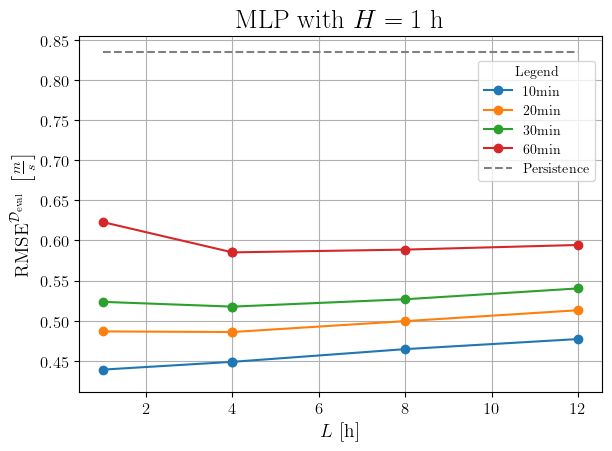

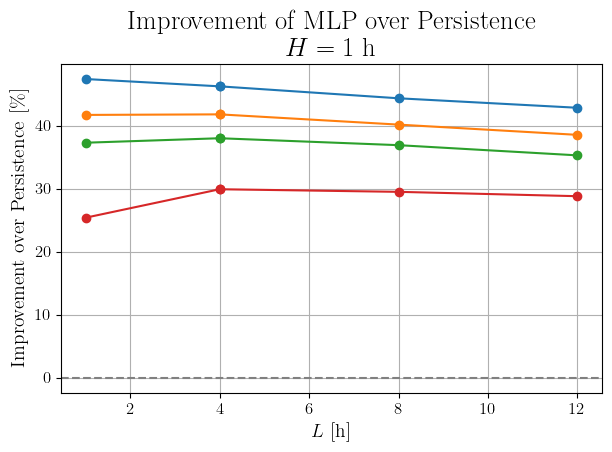

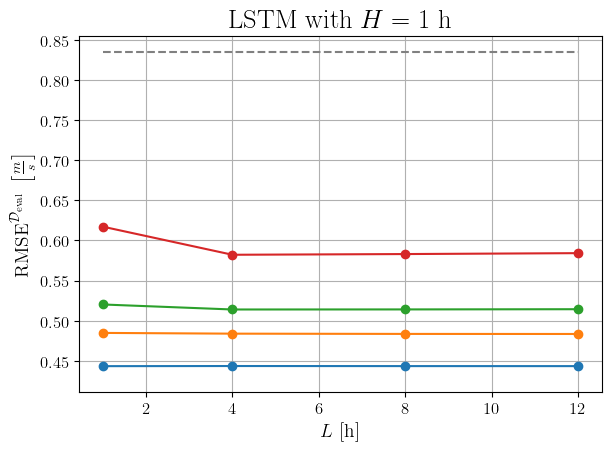

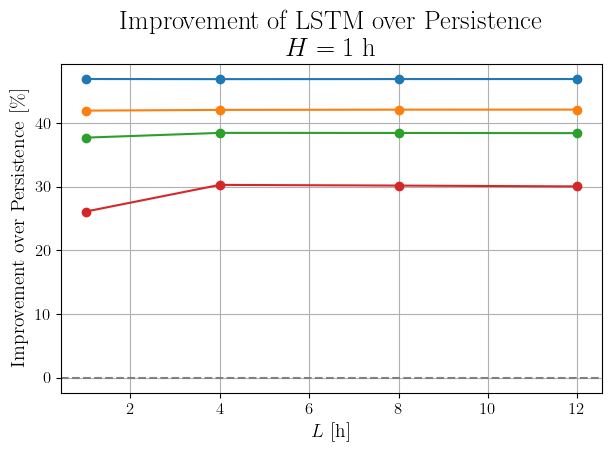

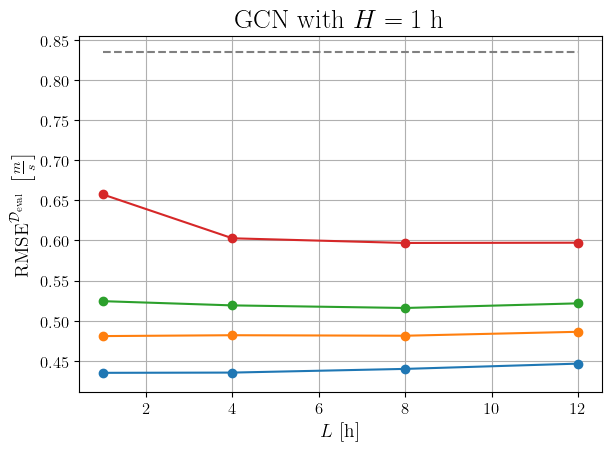

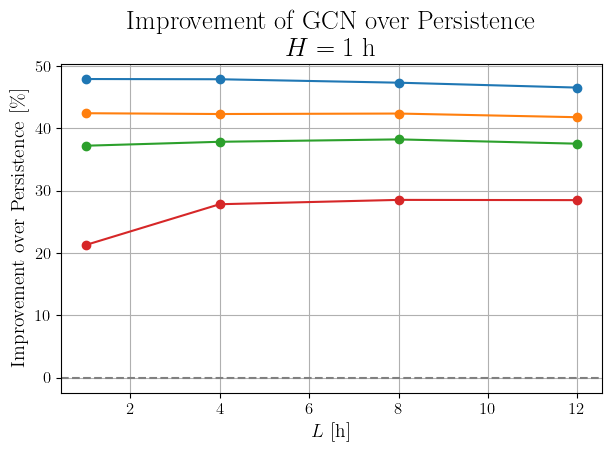

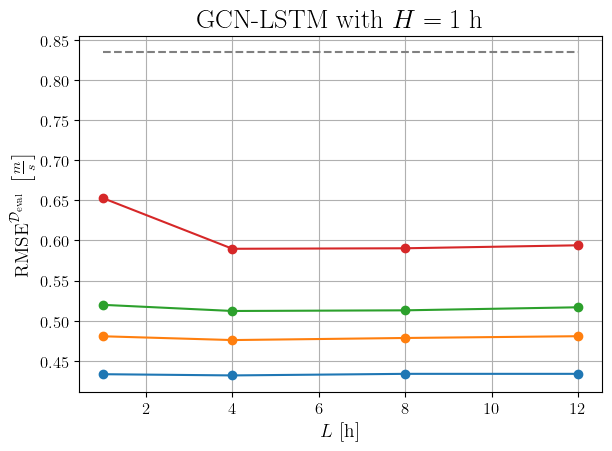

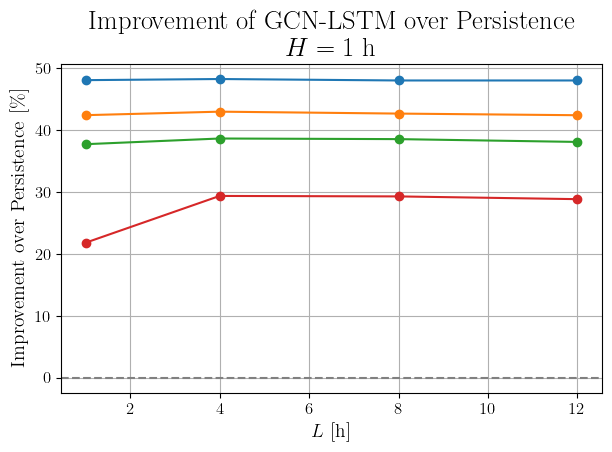

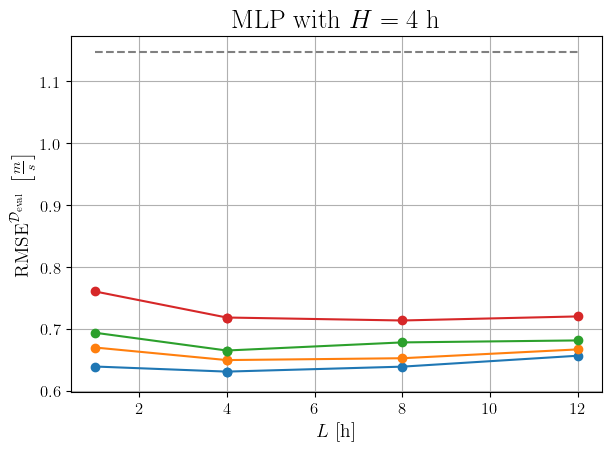

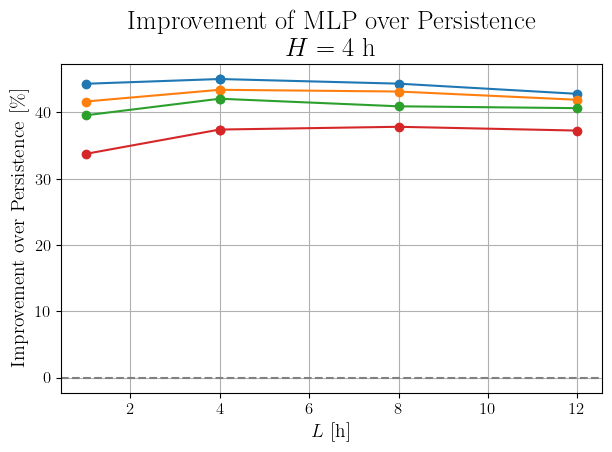

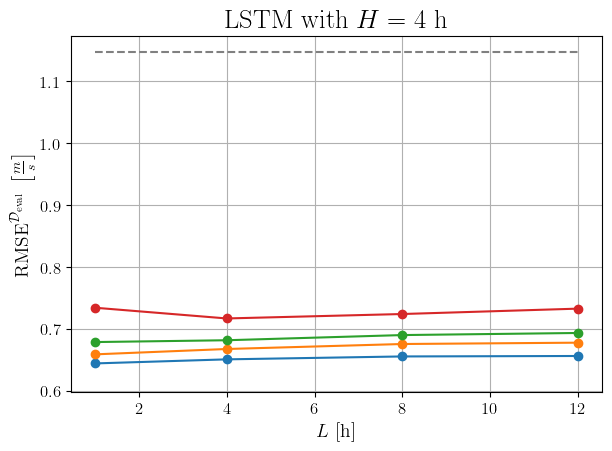

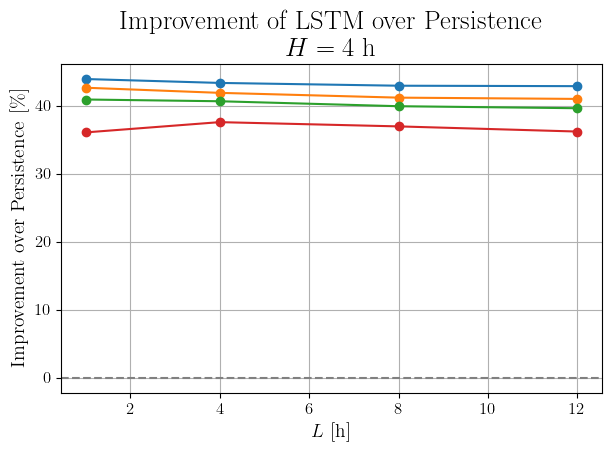

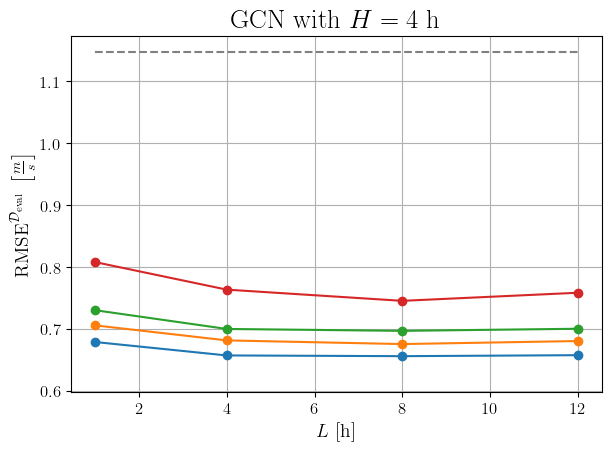

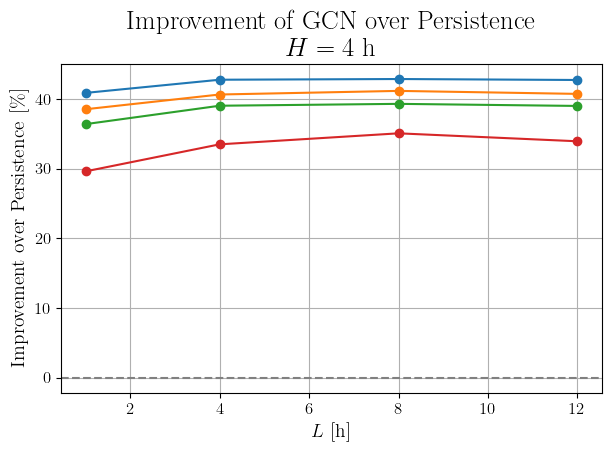

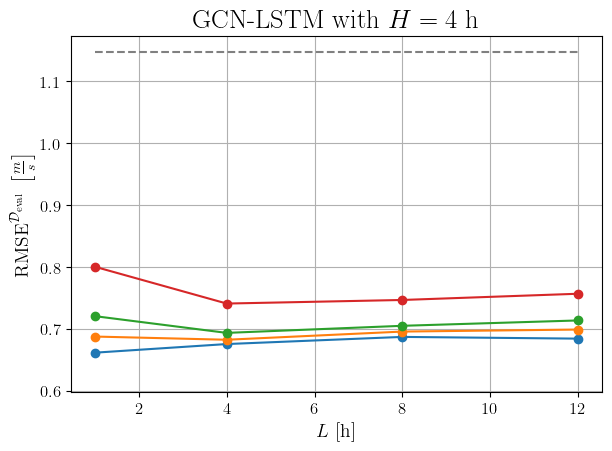

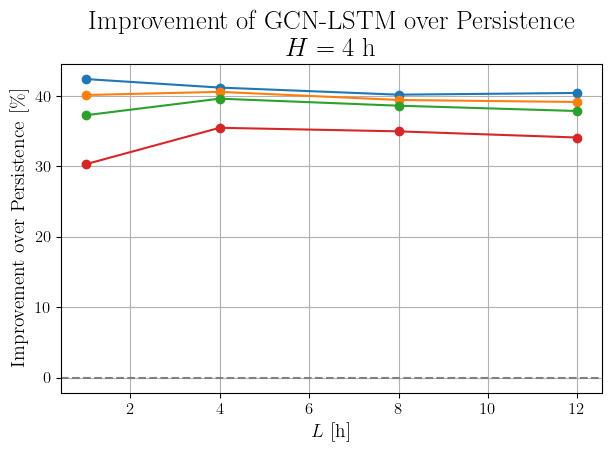

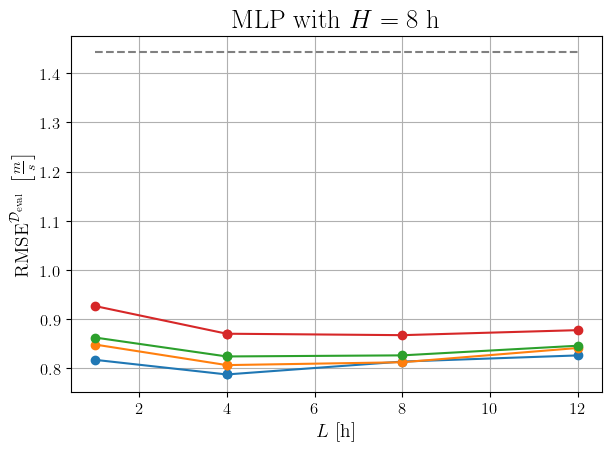

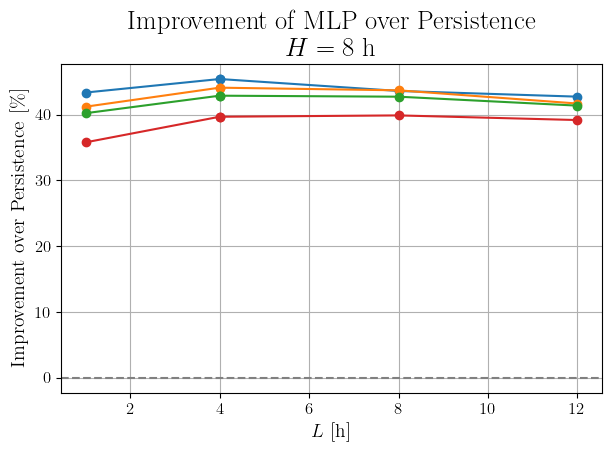

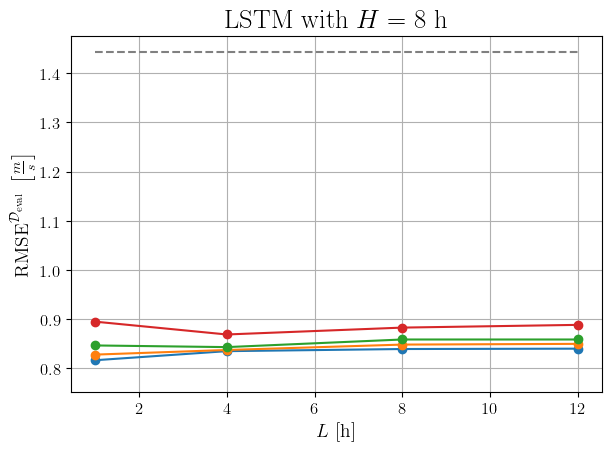

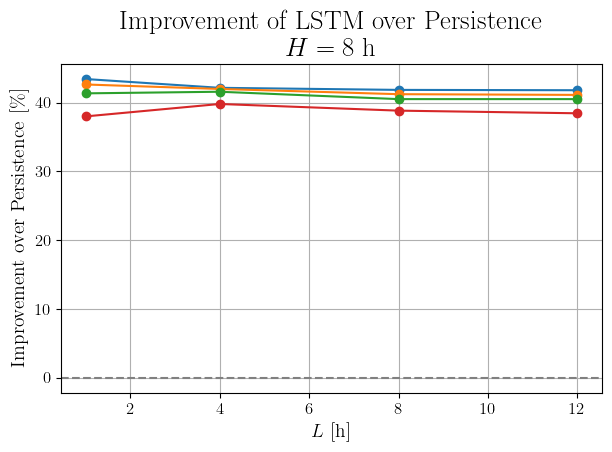

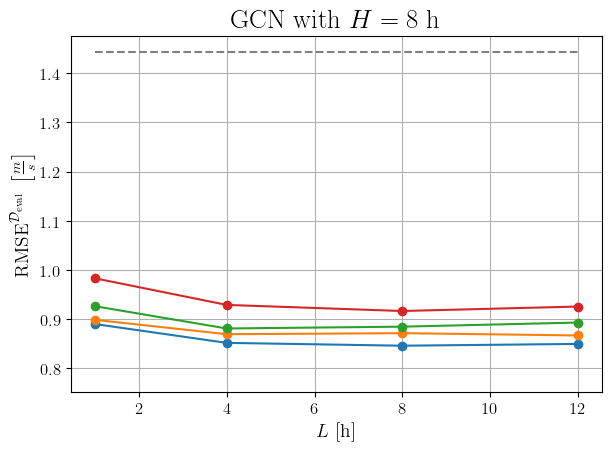

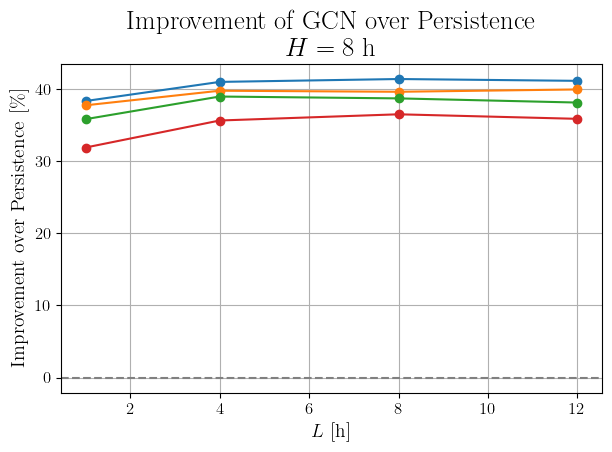

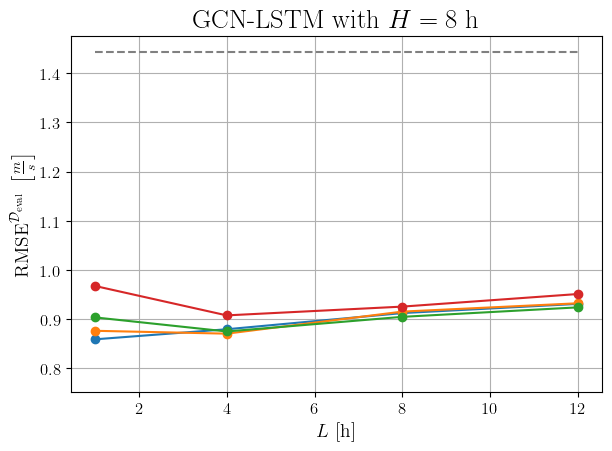

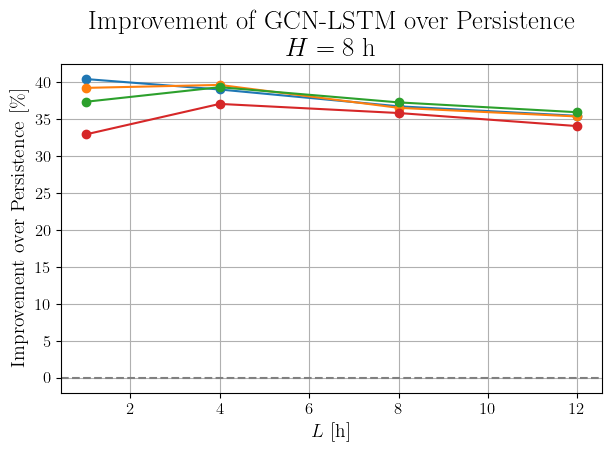

In [71]:
architectures = ["mlp", "lstm", "gcn", "gcn_lstm"]
resolutions = ["10min", "20min", "30min", "60min"]
look_back_hours = [1, 4, 8, 12]
horizons = [1, 4, 8]
results_df["forecasting_hours"] = results_df["forecasting_hours"].astype(int)

plot_legend = True

for horizon in horizons:
    # Compute global min and max RMSE for consistent y-axis
    horizon_subset = results_df[results_df["forecasting_hours"] == horizon]
    rmse_vals = horizon_subset[horizon_subset["model_architecture"].isin(architectures)]["RMSE"]
    persistence_vals = results_df[
        (results_df["model_architecture"] == "persistence") &
        (results_df["forecasting_hours"] == horizon)
    ]["RMSE"]

    global_min = min(rmse_vals.min(), persistence_vals.min())
    global_max = max(rmse_vals.max(), persistence_vals.max())

    margin = 0.05 * (global_max - global_min)
    y_min, y_max = global_min - margin, global_max + margin

    # Get scalar persistence RMSE (assuming it's constant per horizon)
    persistence_rmse = persistence_vals.values[0] if len(persistence_vals) > 0 else None

    for arch in architectures:
        subset = horizon_subset[horizon_subset["model_architecture"] == arch]

        # ==== RMSE Plot ====
        plt.figure()
        for res in resolutions:
            sub_res = subset[
                (subset["resolution"] == res) & (subset["look_back_hours"].isin(look_back_hours))
            ]
            sub_res = sub_res.sort_values("look_back_hours")

            plt.plot(
                sub_res["look_back_hours"],
                sub_res["RMSE"],
                marker="o",
                label=str(res),
            )

        # Add persistence baseline
        plt.hlines(
            y=persistence_rmse,
            xmin=min(look_back_hours),
            xmax=max(look_back_hours),
            colors="gray",
            linestyles="dashed",
            label="Persistence",
        )

        plt.xlabel("$L$ [h]")
        plt.ylabel(r"$\text{RMSE}^{\mathcal{D}_{\text{eval}}} \; \left[ \frac{m}{s} \right]$")
        plt.title(
            f"{'GCN-LSTM' if arch == 'gcn_lstm' else arch.upper()} with " + rf"$H = {horizon}$ h"
        )
        plt.ylim(y_min, y_max)

        if plot_legend:
            plt.legend(title="Legend", bbox_to_anchor=(1.00, 0.95))
            plot_legend = False

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if persistence_rmse is not None and persistence_rmse != 0:
            plt.figure()
            for res in resolutions:
                sub_res = subset[
                    (subset["resolution"] == res) & (subset["look_back_hours"].isin(look_back_hours))
                ]
                sub_res = sub_res.sort_values("look_back_hours")

                # Compute percentage improvement
                improvement_percent = (1 - sub_res["RMSE"] / persistence_rmse) * 100

                plt.plot(
                    sub_res["look_back_hours"],
                    improvement_percent,
                    marker="o",
                    label=str(res),
                )

            plt.axhline(0, color="gray", linestyle="dashed")
            plt.xlabel("$L$ [h]")
            plt.ylabel(r"Improvement over Persistence [\%]")
            plt.title(
                f"Improvement of {'GCN-LSTM' if arch == 'gcn_lstm' else arch.upper()} over Persistence\n"
                + rf"$H = {horizon}$ h"
            )
            plt.grid(True)
            plt.tight_layout()
            plt.show()
